<a href="https://www.kaggle.com/code/siladurtas/a-large-scale-fish-ann?scriptVersionId=203179853" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Kütüphaneler
Gerekli kütüphaneler yüklendi.

- **pandas**: Veri analizi ve veri manipülasyonu için kullanılır. Tablo benzeri veri yapıları (DataFrame) sağlar.
- **numpy**: Sayısal işlemler ve çok boyutlu diziler için kullanılır.
- **os**: İşletim sistemi ile etkileşim kurmak, dosya ve dizin işlemleri için kullanılır.
- **pathlib**: Dosya yollarını nesne tabanlı yönetmek için kullanılır.
- **matplotlib**: Veri görselleştirme kütüphanesi, grafikler ve görseller oluşturur.
- **warnings**: Python kodunda uyarı mesajlarını yönetmek ve devre dışı bırakmak için kullanılır.
- **tensorflow**: Derin öğrenme modelleri oluşturmak, eğitmek ve çalıştırmak için kullanılan bir kütüphane.
- **PIL (Pillow)**: Görüntü işleme işlemleri için kullanılır.
- **scikit-learn**: Makine öğrenimi modelleri, veri ön işleme ve model değerlendirme için kullanılır.
- **scikeras.wrappers**: scikit-learn ve Keras modellerini entegre eder.
- **skopt (BayesSearchCV)**: Hiperparametre optimizasyonu için kullanılan kütüphane.


In [32]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier

In [33]:
# Gerekli kütüphaneleri 
import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from skopt import BayesSearchCV
from skopt.space import Integer, Real

## Uyarılar
Uyarılar devre dışı bırakıldı.

## GPU Kontrolü
Mevcut GPU'lar listelendi.## Uyarılar
Uyarılar devre dışı bırakıldı.

## GPU Kontrolü
Mevcut GPU'lar listelendi.

In [34]:
# Uyarıları devre dışı bırak
warnings.filterwarnings('ignore')

# GPU aygıtlarını listele
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Veri Yolu
Görüntülerin bulunduğu dizin ayarlandı. `Path` kütüphanesi kullanılarak belirli bir klasördeki görüntü dosyalarının tümü toplandı. Bu, model eğitiminde kullanılacak verilerin kolayca yönetilmesini sağlar.

## Dosya Yolları ve Etiketler
Görüntülerin bulunduğu dosya yolları ve her görüntü için kategori etiketleri çıkarıldı. Dosya yolları görüntülerin nereye kaydedildiğini gösterirken, etiketler her görüntünün ait olduğu sınıfı temsil eder. Bu, sınıflandırma modelinin görüntüleri hangi kategoriye ait olduklarını öğrenmesini sağlar.

## Pandas Serisi
Dosya yolları ve etiketler, analiz ve manipülasyon için Pandas Serisi'ne dönüştürüldü. Bu, verilerin daha kolay işlenebilmesini ve daha fazla veri analizi yapılmasını sağlar.

## Birleştirme
Dosya yolları ve etiketler yan yana birleştirildi ve bir DataFrame oluşturuldu. Böylece her görüntü yolu ile ilgili etiketi aynı satırda tutarak verilerin düzenli bir yapıda saklanmasını sağlar.

## GT Filtreleme
Görüntü etiketleri içinde 'GT' ile bitenler çıkarıldı. Bu adım, gereksiz veya yanlış etiketlenmiş verilerin model eğitimine dahil edilmemesi için yapılır. Bu tür veriler genellikle eğitim verisinin bir parçası değildir.

## Veri Karıştırma
Veriler rastgele karıştırıldı ve indeksleri sıfırlandı. Bu, model eğitiminde önyargıları önlemek için yapılır. Karıştırma, verilerin belirli bir sırada olmamasını sağlar ve modelin tüm veri çeşitlerini öğrenmesine yardımcı olur.


In [35]:
# Görüntü dizinini belirle
image_dir = Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

# Dosya yollarını ve etiketleri al
filepaths = list(image_dir.glob(r'**/*.png'))  # .png dosyalarını alt dizinlerle birlikte bul
labels = [os.path.split(os.path.split(fp)[0])[1] for fp in filepaths]  # Etiketleri dosya yolundan çıkar

# Dosya yolları ve etiketleri Pandas Serisi'ne dönüştür
filepaths = pd.Series(filepaths, name='Dosya Yolları').astype(str)
labels = pd.Series(labels, name='Etiketler')

# Dosya yolları ve etiketleri birleştir
image_df = pd.concat([filepaths, labels], axis=1)

# GT resimlerini çıkar (etiketi 'GT' ile bitenleri filtrele)
image_df = image_df[~image_df['Etiketler'].str.endswith('GT')]

# DataFrame'i karıştır ve indeksleri sıfırla
image_df = image_df.sample(frac=1).reset_index(drop=True)

# Örnek Görseller
Her sınıftan bir görüntü örneği seçildi. Bu adım, veri setinin çeşitliliğini ve her bir sınıfın temsilini gözlemlemek için önemlidir. Farklı sınıflara ait örnekler, modelin eğitilmesi sırasında hangi tür görüntülerle çalışılacağını anlamaya yardımcı olur.

## Alt Grafik
Seçilen örnekler, bir alt grafik içinde gösterildi. Alt grafik, her bir sınıfın örnek görüntülerini yan yana yerleştirerek görsel bir karşılaştırma sağlar. Bu, kullanıcıların her sınıfın özelliklerini hızlıca değerlendirmesine olanak tanır. Her görüntünün üzerinde ilgili sınıfın etiketi de belirtilerek, hangi sınıfın hangi örnekle temsil edildiği açıkça ifade edilir. Böylece, veri setinin dengesi ve çeşitliliği hakkında bir fikir edinmek mümkün olur.


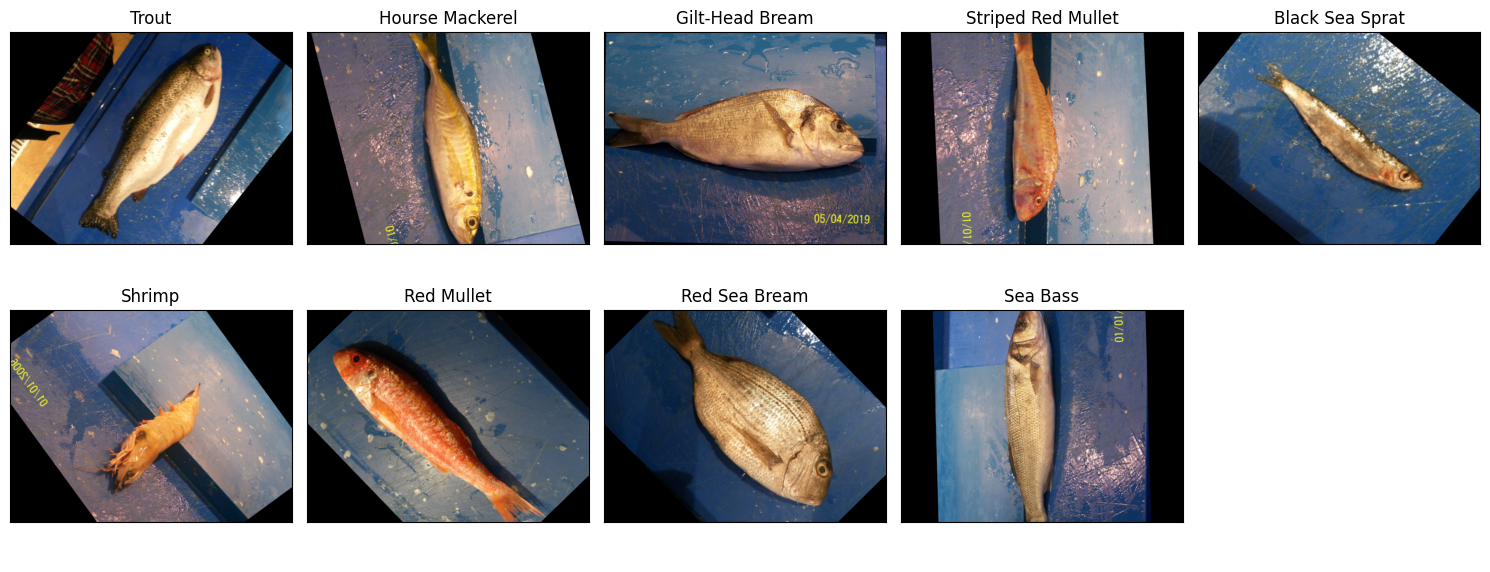

In [36]:
# Her sınıftan bir örnek seçme
unique_labels = image_df['Etiketler'].unique()
sample_images = []
for label in unique_labels:
    sample_image_path = image_df[image_df['Etiketler'] == label]['Dosya Yolları'].iloc[0]
    sample_images.append((sample_image_path, label))

# Alt grafik oluşturma
n_samples = len(sample_images)
ncols = 5
nrows = (n_samples // ncols) + (n_samples % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows), 
                         subplot_kw={'xticks': [], 'yticks': []})
for ax, (image_path, label) in zip(axes.flat, sample_images):
    ax.imshow(plt.imread(image_path))
    ax.set_title(label)

for ax in axes.flat[len(sample_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Etiket Dağılımı
Etiketlerin dağılımı, çubuk ve pasta grafiği ile görselleştirildi. Bu adım, veri setindeki her sınıfın temsil oranını anlamak için kritik öneme sahiptir. 

### Neden Yapıldı?
- **Veri Dengesizliği Analizi**: Sınıflar arasındaki örnek sayılarının eşit olup olmadığını kontrol etmek, modelin genel performansını etkileyen önemli bir faktördür. Dengesiz bir veri seti, modelin bazı sınıfları öğrenmesini zorlaştırabilir ve bu da sınıflandırma hatalarına yol açabilir.

- **Sınıf Temsili**: Görselleştirme, her bir sınıfın veri setindeki temsilini net bir şekilde ortaya koyarak, hangi sınıfların daha fazla veya daha az temsil edildiğini gösterir. Bu, gerektiğinde veri artırma veya dengesizliği gidermek için ek veri toplama gibi stratejilerin uygulanmasına yardımcı olur.

### Grafiklerin Kullanımı
- **Çubuk Grafiği**: Çubuk grafiği, her bir etiketin kaç örnek içerdiğini göstererek, etiketlerin sayısal dağılımını anlamaya yardımcı olur. Görsel olarak, hangi sınıfların daha fazla temsil edildiği hemen anlaşılabilir.

- **Pasta Grafiği**: Pasta grafiği ise, her sınıfın toplam veri setine oranını gösterir. Bu, kullanıcıların görsel olarak her sınıfın veri setindeki payını hızlıca değerlendirmelerine olanak tanır. Her iki grafik türü de, veri setinin genel yapısını daha iyi anlamaya yardımcı olur ve model geliştirme sürecinde veriyle ilgili stratejik kararlar alınmasına katkıda bulunur.


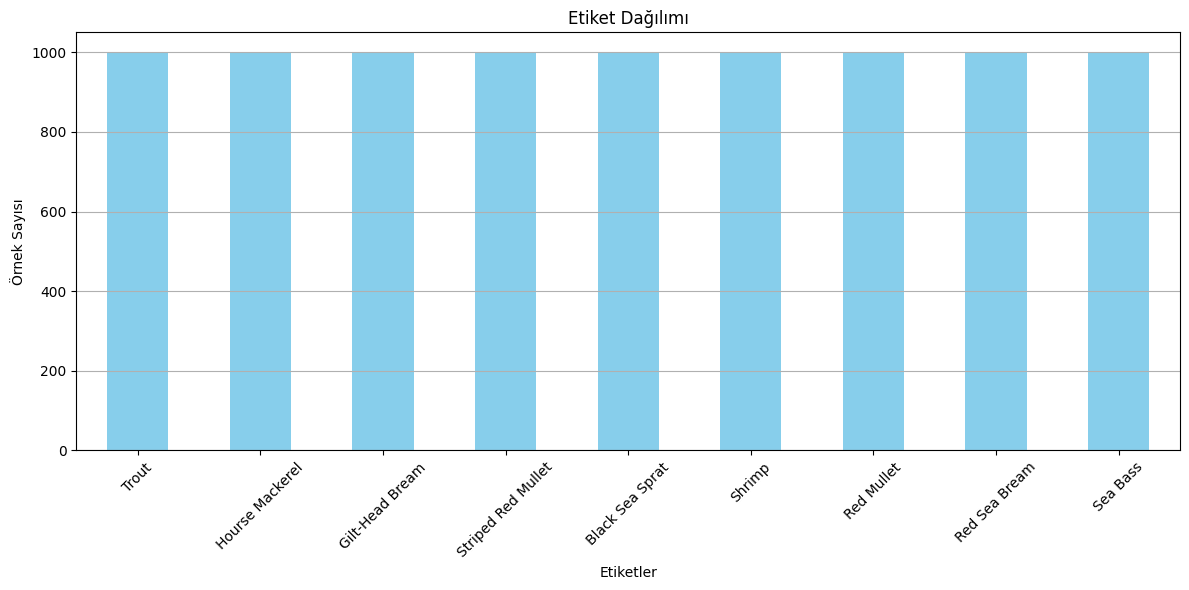

In [37]:
# Etiketlerin sayısını hesapla ve grafikleri oluştur
label_counts = image_df['Etiketler'].value_counts()

plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Etiket Dağılımı')
plt.xlabel('Etiketler')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Her sınıfta 1000 veri olması, sınıfların dengeli olduğu anlamına gelir. Dengeli veri setleri, modelin aşırı veya az öğrenme riskini azaltır.

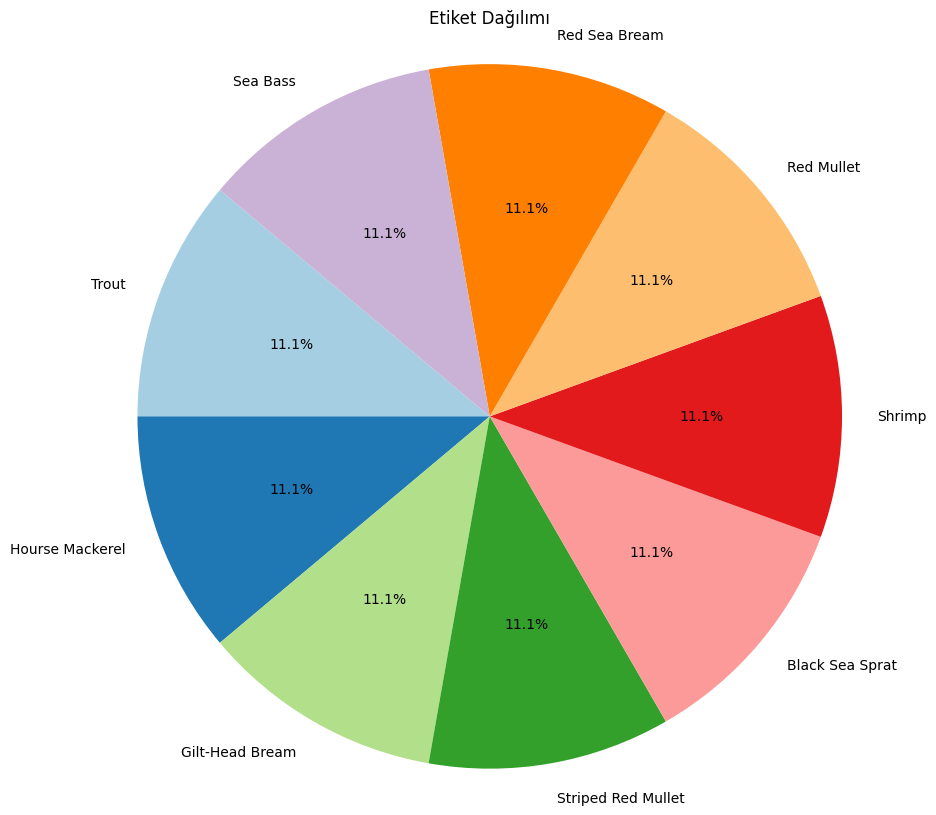

In [38]:
plt.figure(figsize=(10, 10))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Etiket Dağılımı')
plt.axis('equal')
plt.show()

# Veri Bölme
Veriler, modelin eğitim, doğrulama ve test setlerine ayrılması için bölündü. Bu ayrım, makine öğrenimi ve derin öğrenme süreçlerinde kritik bir adımdır ve modelin genel performansını artırmak amacıyla yapılır.

### Eğitim Seti (Train Set)
- **Tanım**: Eğitim seti, modelin öğrenmesi için kullanılan verileri içerir. Model, bu veri kümesinden özellikleri öğrenir ve sınıflandırma veya regresyon gibi görevleri gerçekleştirmek için gerekli parametreleri optimize eder.
- **Amaç**: Modelin, veri üzerinde en iyi performansı gösterebilmesi için eğitim setinden öğrenmesi hedeflenir. Bu süreçte, modelin genelleme yeteneğini artırmak için çeşitli stratejiler (örneğin, veri artırma) uygulanabilir.

### Doğrulama Seti (Validation Set)
- **Tanım**: Doğrulama seti, modelin eğitim süreci sırasında performansını değerlendirmek için kullanılır. Model, bu veri kümesi üzerinde test edilerek hiperparametreler ve model mimarisi hakkında geri bildirim alınır.
- **Amaç**: Modelin aşırı öğrenme (overfitting) riskini azaltmak için doğrulama seti kullanılır. Doğrulama setinin amacı, modelin eğitim sırasında gerçek dünya verilerine ne kadar iyi genelleme yapabileceğini kontrol etmektir. Bu sayede, modelin performansı optimize edilir.

### Test Seti (Test Set)
- **Tanım**: Test seti, modelin eğitim ve doğrulama sürecinden tamamen ayrı bir veri kümesidir. Modelin gerçek performansını değerlendirmek için son aşamada kullanılır.
- **Amaç**: Test seti, modelin genel performansını ölçmek için kritik öneme sahiptir. Eğitim ve doğrulama süreçlerinde kullanılan verilere maruz kalmayan bu veri kümesi, modelin ne kadar iyi genelleme yaptığını ve yeni verilere ne kadar dayanıklı olduğunu gösterir.

### Neden Bölündü?
Verilerin bu şekilde bölünmesi, birkaç önemli neden taşır:
- **Genelleme Yeteneği**: Eğitim, doğrulama ve test setlerinin ayrılması, modelin yeni, görülmemiş verilere ne kadar iyi genelleme yapabildiğini anlamak için gereklidir. Bu, modelin gerçek dünya uygulamalarında daha etkili olmasını sağlar.
- **Aşırı Öğrenme Önleme**: Modelin eğitim verisi üzerinde aşırı öğrenmesini engellemek için doğrulama seti kullanılır. Aşırı öğrenme, modelin eğitim verisi üzerinde çok iyi performans göstermesine rağmen, yeni verilere kötü yanıt vermesine neden olabilir.
- **Model Değerlendirmesi**: Sonuçların güvenilir bir şekilde değerlendirilmesi için test seti kullanılır. Test seti, modelin başarısını ölçmek ve farklı model yapılandırmalarının karşılaştırmasını yapmak için önemlidir.

Bu süreç, modelin hem eğitim hem de uygulama aşamasında yüksek doğruluk oranı sağlamasına katkıda bulunur.


In [39]:
# Eğitim, doğrulama ve test setlerine ayır
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['Etiketler'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Etiketler'])


# Görüntü İşleme
Görüntüler, modelin daha iyi performans göstermesi için boyutlandırılıp normalleştirildi. 

### Boyutlandırma
- **Tanım**: Görüntü boyutlandırma, tüm görüntülerin aynı boyutta olması için yeniden boyutlandırılması işlemidir. Bu, modelin daha verimli çalışmasını sağlamak için önemlidir.
- **Amaç**: Derin öğrenme modelleri, genellikle sabit boyutlu girdi gerektirir. Farklı boyutlardaki görüntülerin kullanılması, modelin eğitim sürecini zorlaştırabilir. Bu nedenle, tüm görüntüler aynı boyutta olacak şekilde ayarlanır.

### Normalleştirme
- **Tanım**: Normalleştirme, görüntü verilerinin belirli bir ölçeğe (genellikle 0 ile 1 arasında) dönüştürülmesidir. Bu, piksel değerlerinin belirli bir aralığa çekilmesi anlamına gelir.
- **Amaç**: Normalleştirme, modelin daha hızlı ve etkili bir şekilde öğrenmesini sağlar. Farklı ölçeklerdeki veriler, modelin öğrenme sürecini olumsuz etkileyebilir. Normalleştirme, bu etkileri azaltarak modelin performansını artırır.

# Etiket Kodlama
Etiketler, makine öğrenimi modellerinde kullanılabilir hale getirilmek için iki temel yöntemle dönüştürüldü: **label encoding** ve **one-hot encoding**.

### Label Encoding
- **Tanım**: Label encoding, her bir benzersiz etikete bir tam sayı atanması işlemidir. Örneğin, 'kedi' 0, 'köpek' 1 olarak kodlanabilir.
- **Amaç**: Bu yöntem, etiketlerin sayısal verilere dönüştürülmesini sağlar. Ancak, label encoding, bazı durumlarda modelin yanlış yorumlamasına neden olabilir, çünkü sıralı bir ilişki yaratabilir.

### One-Hot Encoding
- **Tanım**: One-hot encoding, her bir etiket için ayrı bir ikili sütun oluşturur. Örneğin, 'kedi' ve 'köpek' için iki sütun oluşturulur; 'kedi' için [1, 0], 'köpek' için [0, 1] gösterilir.
- **Amaç**: One-hot encoding, etiketler arasındaki sıralı ilişkilerin ortadan kaldırılmasını sağlar ve modelin her etiketi bağımsız olarak değerlendirmesine olanak tanır. Bu yöntem, özellikle çok sınıflı sınıflandırma görevlerinde yaygın olarak kullanılır.

### Neden Yapıldı?
Etiket kodlaması, makine öğrenimi modellerinin doğru ve etkili bir şekilde çalışabilmesi için gereklidir. Her iki yöntemin de kullanım amacı, modelin etiketleri sayısal verilere dönüştürerek öğrenmesini sağlamaktır. Bu dönüşüm, modelin performansını artırır ve verinin işlenmesini kolaylaştırır. Doğru bir kodlama yöntemi seçmek, modelin genelleme yeteneğini de olumlu yönde etkileyebilir.


In [40]:
# Görüntü işleme fonksiyonu
def preprocess_images(df):
    images = []
    for image_path in df['Dosya Yolları']:
        with Image.open(image_path) as img:
            img = img.convert('L')  # Siyah-beyaz dönüşüm
            img = img.resize((128, 128))  # Görüntüyü yeniden boyutlandır
            img_array = np.array(img).flatten()  # Görüntüyü düzleştir
            img_array = img_array / 255.0  # Normalizasyon
            images.append(img_array)
    return np.array(images)

# Eğitim, doğrulama ve test setlerini işle
X_train = preprocess_images(train_df)
X_val = preprocess_images(val_df)
X_test = preprocess_images(test_df)

# Etiketleri kodla (Label Encoding ve One-Hot Encoding)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['Etiketler'])
y_val_encoded = label_encoder.transform(val_df['Etiketler'])
y_test_encoded = label_encoder.transform(test_df['Etiketler'])

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val_encoded.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test_encoded.reshape(-1, 1))

In [41]:
# Sonuçları kontrol et
print(f"Eğitim seti görüntüleri boyutu: {X_train.shape}")  # Eğitim seti görüntü boyutunu yazdır
print(f"Doğrulama seti görüntüleri boyutu: {X_val.shape}")  # Doğrulama seti görüntü boyutunu yazdır
print(f"Test seti görüntüleri boyutu: {X_test.shape}")  # Test seti görüntü boyutunu yazdır
print(f"Eğitim etiketleri boyutu (Label Encoded): {y_train_encoded.shape}")  # Eğitim etiketlerinin boyutunu yazdır
print(f"Doğrulama etiketleri boyutu (Label Encoded): {y_val_encoded.shape}")  # Doğrulama etiketlerinin boyutunu yazdır
print(f"Test etiketleri boyutu (Label Encoded): {y_test_encoded.shape}")  # Test etiketlerinin boyutunu yazdır
print(f"Eğitim etiketleri boyutu (One-Hot Encoded): {y_train_one_hot.shape}")  # Eğitim etiketlerinin boyutunu yazdır
print(f"Doğrulama etiketleri boyutu (One-Hot Encoded): {y_val_one_hot.shape}")  # Doğrulama etiketlerinin boyutunu yazdır
print(f"Test etiketleri boyutu (One-Hot Encoded): {y_test_one_hot.shape}")  # Test etiketlerinin boyutunu yazdır

Eğitim seti görüntüleri boyutu: (5760, 16384)
Doğrulama seti görüntüleri boyutu: (1440, 16384)
Test seti görüntüleri boyutu: (1800, 16384)
Eğitim etiketleri boyutu (Label Encoded): (5760,)
Doğrulama etiketleri boyutu (Label Encoded): (1440,)
Test etiketleri boyutu (Label Encoded): (1800,)
Eğitim etiketleri boyutu (One-Hot Encoded): (5760, 9)
Doğrulama etiketleri boyutu (One-Hot Encoded): (1440, 9)
Test etiketleri boyutu (One-Hot Encoded): (1800, 9)


# Model oluşturma fonksiyonu
Belirtilen katman, nöron sayısı ve optimizer ile modelin oluşturulması sağlanır.


In [42]:
# Model oluşturma fonksiyonu
def create_model(num_layers=1, num_nodes=32, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(num_nodes, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    for _ in range(1, num_layers):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(y_train_one_hot.shape[1], activation='softmax'))
    opt = Adam() if optimizer == 'adam' else SGD()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# KerasClassifier içinde modeli sar
Model, Keras kütüphanesi ile oluşturulduktan sonra, **KerasClassifier** sınıfı kullanılarak sarılır. Bu, Keras modelinin scikit-learn ile uyumlu hale getirilmesini sağlar ve modelin daha kolay bir şekilde eğitim, doğrulama ve test süreçlerine entegre edilmesine olanak tanır.

### Neden KerasClassifier Kullanılır?
- **Uyumluluk**: Keras modellerinin scikit-learn API'si ile uyumlu hale getirilmesini sağlar. Bu, diğer scikit-learn araçları ile entegrasyonu kolaylaştırır.
- **Kolay Kullanım**: KerasClassifier, modelin eğitimi, tahmini ve değerlendirilmesi gibi işlemleri basitleştirir. Scikit-learn'in fit, predict ve score metodları ile kullanılabilir.
- **Hyperparametre Ayarı**: KerasClassifier kullanarak, modelin hiperparametrelerini scikit-learn araçlarıyla kolayca ayarlamak mümkündür.

## Bayes Arama CV ile hiperparametre optimizasyonu
Modelin hiperparametreleri, **Bayes Arama CV** (Bayesian Optimization with Cross-Validation) yöntemi ile optimize edilir. Bu yöntem, hiperparametrelerin en iyi kombinasyonlarını bulmak için istatistiksel bir yaklaşım kullanır.

### Hiperparametre Optimizasyonu Nedir?
- **Tanım**: Hiperparametre optimizasyonu, bir modelin performansını artırmak için modelin ayarlarını en iyi hale getirme sürecidir. Hiperparametreler, modelin eğitim sürecinde sabit kalan, ancak modelin öğrenme yeteneğini etkileyen ayarlardır.

### Bayes Arama CV Nasıl Çalışır?
1. **Bayes Teoremi**: Bu yöntem, Bayes teoremi temelinde çalışır. İlk olarak, belirli bir hiperparametre kombinasyonunun modelin performansına olan etkisi hakkında bir ön bilgi (prior) oluşturulur.
2. **Gözlemler ve Güncellemeler**: Modelin her bir hiperparametre kombinasyonu için yapılan gözlemler (örneğin, doğruluk veya kayıp) kullanılarak bu ön bilgi güncellenir. Yani, elde edilen sonuçlar modelin daha iyi bir tahmin yapabilmesi için kullanılır.
3. **Etkileşim**: Bayes arama, bu süreçte her bir deneme için performans ölçütlerini analiz eder ve en iyi performansı gösteren hiperparametreleri bulmak için denemeler yapar.
4. **Cross-Validation**: Bu optimizasyon süreci, modelin daha sağlam ve genelleştirilebilir sonuçlar elde etmesini sağlamak için çapraz doğrulama yöntemleri ile desteklenir.

### Neden Bayes Arama CV Kullanılır?
- **Verimlilik**: Hiperparametre optimizasyonu genellikle zaman alıcıdır. Bayes arama, daha az deneme ile daha iyi sonuçlar elde etme potansiyeline sahiptir.
- **Daha İyi Sonuçlar**: Bu yöntem, hiperparametre alanında daha fazla bilgi edinilmesine olanak tanıyarak, modelin genel performansını artırabilir.
- **Esneklik**: Hiperparametre arama alanının genişliği, Bayes arama ile etkili bir şekilde yönetilebilir. 

Bayes Arama CV ile hiperparametre optimizasyonu, KerasClassifier ile entegre edildiğinde, derin öğrenme modellerinin performansını önemli ölçüde artırabilir.


In [43]:
# KerasClassifier içinde modeli sar
model = KerasClassifier(model=create_model, verbose=1)

# Bayes Arama CV ile hiperparametre optimizasyonu
search_space = {
    'model__num_layers': Integer(2, 4),
    'model__num_nodes': Integer(32, 128),
    'model__dropout_rate': Real(0.2, 0.5),
    'model__optimizer': ['adam', 'sgd'],
    'epochs': Integer(20, 50),
    'batch_size': Integer(16, 64)
}
bayes_search = BayesSearchCV(estimator=model, search_spaces=search_space, n_iter=20, cv=3, random_state=42)

## Model Kaydetme
En iyi hiperparametreler ile model kaydedildi.

In [ ]:
bayes_search_result = bayes_search.fit(X_train, y_train_one_hot)

Epoch 1/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.1111 - loss: 2.5762
Epoch 2/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1030 - loss: 2.1982
Epoch 3/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1148 - loss: 2.1967
Epoch 4/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1113 - loss: 2.1977
Epoch 5/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1101 - loss: 2.1976
Epoch 6/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1120 - loss: 2.1974
Epoch 7/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1042 - loss: 2.1972
Epoch 8/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1119 - loss: 2.1969
Epoch 9/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1192 - loss: 2.1970
Epoch 10/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1240 - loss: 2.1967
Epoch 11/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1232 - loss: 2.1967
Epoch 12/42
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

In [53]:
# En iyi hiperparametreleri al
best_model = bayes_search_result.best_estimator_
print("En iyi hiperparametreler:")
print(best_model.get_params())  # Hiperparametreleri yazdır

# En iyi modeli al
best_model = bayes_search_result.best_estimator_
save_path = "/kaggle/working/best_model.h5"
best_model.model_.save(save_path)

En iyi hiperparametreler:
{'model': <function create_model at 0x7aa1ca735f30>, 'build_fn': None, 'warm_start': False, 'random_state': None, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': 64, 'validation_batch_size': None, 'verbose': 1, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 50, 'class_weight': None, 'model__dropout_rate': 0.2, 'model__num_layers': 2, 'model__num_nodes': 128, 'model__optimizer': 'sgd'}


In [54]:
# Modeli değerlendir
loaded_model = load_model('/kaggle/working/best_model.h5')
val_loss, val_accuracy = loaded_model.evaluate(X_val, y_val_one_hot)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.5987 


## Model Eğitimi
En iyi parametrelerle model eğitildi ve kaydedildi. Model eğitimi sürecinde, seçilen hiperparametreler ile modelin öğrenme süreci başlatılır. Eğitim süreci, modelin verilerden öğrenmesini ve genelleme yeteneğini artırmasını sağlar.

### Eğitim Sürecinin Adımları
1. **Veri Hazırlığı**: Eğitim verileri, normalizasyon ve diğer ön işleme adımları ile hazırlanır.
2. **Eğitim**: Model, belirli sayıda epoch boyunca eğitim verileri üzerinde çalıştırılır. Her epoch, modelin verilerden öğrenme sürecini temsil eder.
3. **Kaydetme**: En iyi sonuçları veren model, disk üzerinde saklanır. Bu, daha sonraki değerlendirme ve tahmin süreçleri için önemlidir.

Modelin eğitim süreci, doğru parametrelerin belirlenmesi ve modelin istenen performansa ulaşması için kritik bir aşamadır.


In [55]:
# Yeni eğitim
best_params = {
    'batch_size': 16,
    'epochs': 50,
    'dropout_rate': 0.2,
    'num_layers': 2,
    'num_nodes': 128,
    'optimizer': 'sgd'
}
model = create_model(dropout_rate=best_params['dropout_rate'], num_layers=best_params['num_layers'], 
                     num_nodes=best_params['num_nodes'], optimizer=best_params['optimizer'])
checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), 
                    epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[checkpoint])

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1754 - loss: 2.1294 - val_accuracy: 0.3271 - val_loss: 1.8026
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2908 - loss: 1.8369 - val_accuracy: 0.4056 - val_loss: 1.6542
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3679 - loss: 1.6806 - val_accuracy: 0.4979 - val_loss: 1.4689
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4308 - loss: 1.5534 - val_accuracy: 0.4819 - val_loss: 1.3940
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4480 - loss: 1.4926 - val_accuracy: 0.4819 - val_loss: 1.4508
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4984 - loss: 1.3975 - val_accuracy: 0.5917 - val_loss: 1.1943
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5292 - loss: 1.3093 - val_accuracy: 0.6028 - val_loss: 1.1908
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5648 - loss: 1.2350 - val_accuracy: 0.

## Kayıp ve Doğruluk Grafiği
Eğitim sürecindeki kayıp ve doğruluk, grafikler aracılığıyla görselleştirildi. Bu grafikler, modelin eğitim süresince nasıl performans gösterdiğini anlamak için kullanılır.

### Grafiklerin Önemi
- **Eğitim Süresi Gözlemi**: Kayıp ve doğruluk grafiklerinin incelenmesi, modelin hangi aşamada iyi veya kötü performans gösterdiğini anlamaya yardımcı olur.
- **Overfitting ve Underfitting**: Grafikler, modelin overfitting (aşırı uyum) veya underfitting (yetersiz uyum) olup olmadığını belirlemeye yardımcı olur. 
  - **Overfitting**: Eğitim kaybı düşerken doğrulama kaybının artması durumu.
  - **Underfitting**: Hem eğitim hem de doğrulama kaybının yüksek olduğu durum.
  
Kayıp ve doğruluk grafiklerinin analizi, modelin genel performansını değerlendirmek ve iyileştirme yollarını belirlemek için önemlidir.


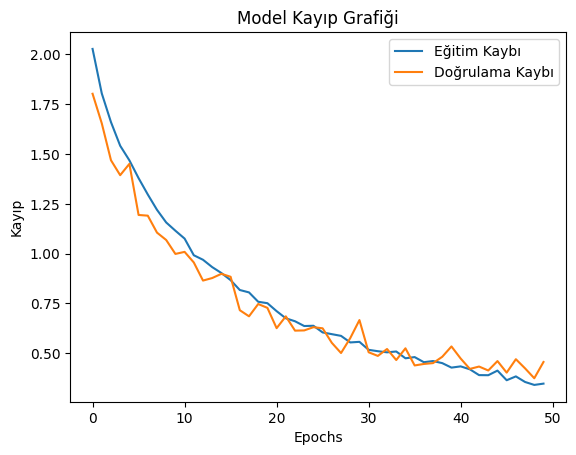

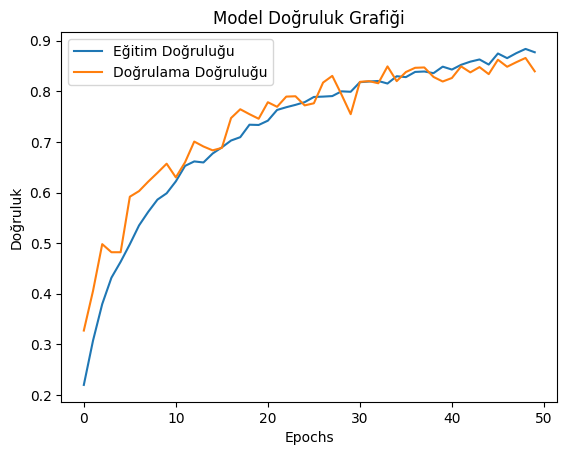

In [56]:
# Eğitim ve doğrulama kayıp/doğruluk grafikleri
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kayıp Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluk Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

Eğitim ve doğrulama doğrulukları oldukça benzer eğilimler sergiliyor, bu da modelin aşırı öğrenme yapmadığını ve doğrulama verisinde de iyi performans gösterdiğini düşündürüyor.

# Sınıflandırma Raporu
Doğrulama seti için sınıflandırma raporu ve karışıklık matrisi gösterildi. Sınıflandırma raporu, modelin farklı sınıflar üzerindeki performansını özetleyen bir rapordur.

### Sınıflandırma Raporu Bileşenleri
- **Doğruluk**: Her sınıf için doğru tahmin oranı.
- **Hata Oranı**: Yanlış tahminlerin oranı.
- **F1 Skoru**: Doğruluk ve hatırlamanın harmonik ortalaması. Sınıf dengesizliğinde özellikle önemlidir.

### Karışıklık Matrisi
Karışıklık matrisi, modelin tahminlerini gerçek sınıflarla karşılaştıran bir matristir. Bu matris, her sınıf için doğru ve yanlış tahminlerin sayısını gösterir.

### Neden Önemlidir?
- **Performans Analizi**: Sınıflandırma raporu ve karışıklık matrisi, modelin hangi sınıfları iyi tahmin ettiğini ve hangi sınıflarda zorluk çektiğini gösterir.
- **İyileştirme Alanları**: Hangi sınıflarda hatalar yapıldığı belirlenerek, modelin geliştirilmesi gereken alanlar tespit edilir.

Bu raporlar, modelin başarısını ölçmek ve gelecekteki iyileştirmeler için yol haritası oluşturmak açısından kritik öneme sahiptir.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sınıflandırma Raporu:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.82      0.88      0.85       160
   Gilt-Head Bream       0.87      0.82      0.85       160
   Hourse Mackerel       0.96      0.78      0.86       160
        Red Mullet       0.80      0.93      0.86       160
     Red Sea Bream       0.87      0.84      0.85       160
          Sea Bass       0.73      0.81      0.77       160
            Shrimp       0.86      0.89      0.87       160
Striped Red Mullet       0.82      0.79      0.81       160
             Trout       0.87      0.82      0.85       160

          accuracy                           0.84      1440
         macro avg       0.84      0.84      0.84      1440
      weighted avg       0.84      0.84      0.84      1440

Confusion Matrix:


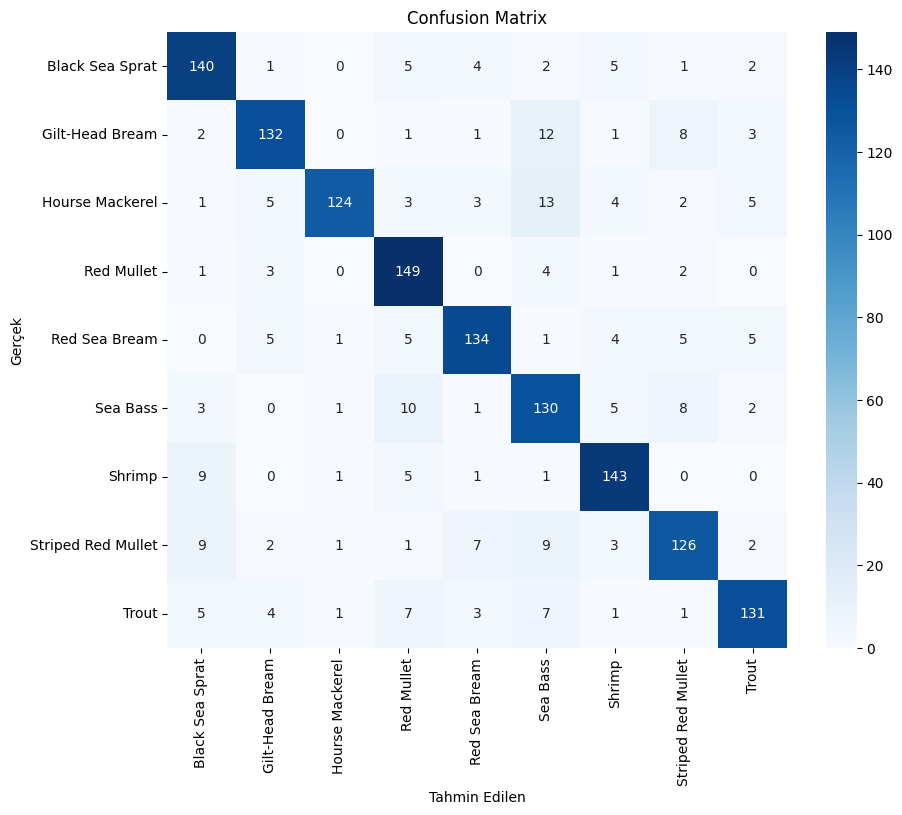

In [57]:
# Sınıflandırma raporu ve confusion matrix
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)
y_true = y_val_one_hot.argmax(axis=-1)

print('Sınıflandırma Raporu:')
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

print('Confusion Matrix:')
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

# Model Eğitimi: 100 Epoch Deneyimi

## Amaç
Bu deneyin temel amacı, modelin eğitim sürecinde 100 epoch kullanarak doğruluk (accuracy) değerinin nasıl değiştiğini gözlemlemek ve olası overfitting durumlarını analiz etmektir. Eğitim sürecinde doğruluk artışlarını incelemek, modelin genel performansını değerlendirmemize yardımcı olacaktır.

- **Kaybın Eğrisi**: Eğitim ve doğrulama kaybı grafikleri, modelin öğrenme sürecinin genel durumunu gösterir. Eğer doğrulama kaybı artıyorsa, bu durum overfitting belirtisi olabilir.
- **Doğruluğun Eğrisi**: Eğitim ve doğrulama doğruluğu grafikleri, modelin her epoch'taki başarısını gösterir. Eğitim doğruluğu ile doğrulama doğruluğu arasındaki farkın artması da overfitting'e işaret edebilir.

## Olası Overfitting Durumları
Eğitim sürecinde dikkat edilmesi gereken en önemli durum, modelin overfitting (aşırı öğrenme) durumuna girmesidir. Aşağıdaki durumlar, overfitting olasılığını işaret edebilir:

- **Yüksek Eğitim Doğruluğu, Düşük Doğrulama Doğruluğu**: Eğitim verisinde yüksek bir doğruluk, ancak doğrulama verisinde düşük doğruluk, modelin sadece eğitim verisine iyi uyum sağladığını gösterir.
- **Doğrulama Kaybının Artması**: Doğrulama kaybı artmaya başlarsa, bu durum modelin genelleme yeteneğinin zayıfladığını gösterir.

## Sonuç
Eğitim sürecinin sonunda elde edilen grafikler, sınıflandırma raporu ve confusion matrix, modelin performansını anlamamıza ve overfitting durumunu değerlendirmemize yardımcı olacaktır. Bu deney, modelin öğrenme sürecini daha iyi kavramak ve gerekli optimizasyonları yapmak için önemli bir adım olacaktır.


In [58]:
# Yeni eğitim ayarları
best_params = {
    'batch_size': 16,
    'epochs': 120,  # EPOCH SAYISINI 120 YAP
    'dropout_rate': 0.2,
    'num_layers': 2,
    'num_nodes': 128,
    'optimizer': 'sgd'
}

# Modeli oluştur
model = create_model(
    dropout_rate=best_params['dropout_rate'], 
    num_layers=best_params['num_layers'], 
    num_nodes=best_params['num_nodes'], 
    optimizer=best_params['optimizer']
)

# Model checkpoint'i tanımla
checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Modeli eğit
history_2 = model.fit(
    X_train, 
    y_train_one_hot, 
    validation_data=(X_val, y_val_one_hot), 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    callbacks=[checkpoint]
)

Epoch 1/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1638 - loss: 2.1422 - val_accuracy: 0.2875 - val_loss: 1.8773
Epoch 2/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3270 - loss: 1.8291 - val_accuracy: 0.4097 - val_loss: 1.6106
Epoch 3/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3849 - loss: 1.6660 - val_accuracy: 0.4410 - val_loss: 1.5827
Epoch 4/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4144 - loss: 1.5692 - val_accuracy: 0.4597 - val_loss: 1.4739
Epoch 5/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4500 - loss: 1.4821 - val_accuracy: 0.4951 - val_loss: 1.3757
Epoch 6/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4843 - loss: 1.3964 - val_accuracy: 0.6028 - val_loss: 1.2210
Epoch 7/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5312 - loss: 1.3120 - val_accuracy: 0.6243 - val_loss: 1.1877
Epoch 8/120
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5620 - loss: 1.2380 - val_accu

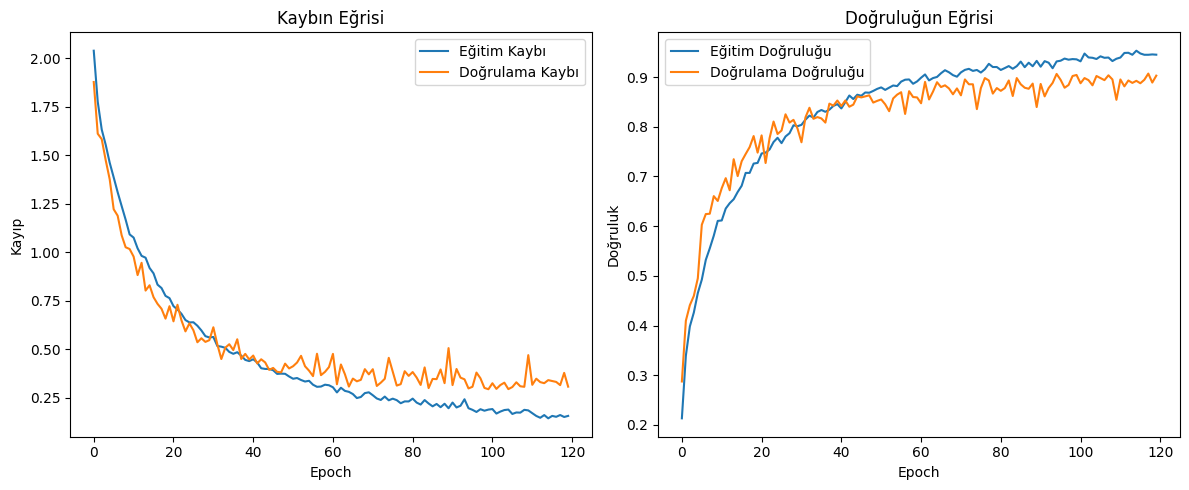

In [59]:
# Loss grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Eğitim Kaybı')
plt.plot(history_2.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kaybın Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history_2.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluğun Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()



Eğitim kaybı sürekli azalmış, doğrulama kaybı ise epoch’lar ilerledikçe daha stabil hale gelmiş. Ancak, 50’den fazla epoch'tan sonra eğitim kaybının düşüşü devam ederken doğrulama kaybı daha küçük dalgalanmalarla sınırlı kalmış. Bu, modelin daha fazla eğitime rağmen doğrulama setinde aşırı iyileşmediğini, ancak kötüleşmediğini de gösteriyor.
Eğitim doğruluğu sürekli artış gösterirken doğrulama doğruluğu bir noktadan sonra neredeyse sabit bir seviyeye ulaşıyor. Doğrulama doğruluğundaki bu dalgalanmalar, modelin eğitim seti üzerinde çok iyi performans göstermesine rağmen doğrulama setinde bu kadar iyi genelleme yapmadığını gösterebilir.

## 1. ve 2. Grafiğin Karşılaştırılması

### Epoch Artışının Etkisi:
İlk grafikte epoch sayısı 50'ydi, burada ise 120’ye çıkarılmış. Epoch sayısının artırılması, eğitim kaybında ve doğruluğunda daha fazla iyileşmeye yol açmış. Eğitim kaybı sürekli olarak azalmış, eğitim doğruluğu ise yükselmeye devam etmiş. Yani daha fazla epoch, modelin eğitim veri seti üzerindeki performansını iyileştirmiş.

### Doğrulama Seti Üzerindeki Performans:
İlk grafikte doğrulama kaybı daha fazla dalgalanma gösterirken, 120 epoch’luk çalışmada doğrulama kaybı daha dengeli ve düşük seviyelerde. Ancak doğrulama doğruluğunda ilk grafikte de bazı dalgalanmalar vardı, bu yeni çalışmada da doğrulama doğruluğunda benzer dalgalanmalar gözlemleniyor. Bu, modelin doğrulama verisi üzerindeki performansının fazla artmadığını, ancak epoch sayısının artmasının genelleme yeteneğine büyük bir katkı sağlamadığını düşündürüyor.

### Aşırı Öğrenme (Overfitting) Riski:
Daha uzun sürede eğitim yapıldığında eğitim doğruluğunun sürekli arttığını ve kaybın azaldığını görüyoruz. Ancak doğrulama seti üzerindeki performans neredeyse sabit kalmış. Bu, modelin aşırı öğrenme yapmaya başlamış olabileceğine işaret edebilir. Yani, model eğitim verisine daha fazla uyum sağlarken doğrulama verisi üzerindeki performansı sabit kalmış veya çok az iyileşmiş. Daha fazla epoch’la modelin genelleme kapasitesinin sınırlı olduğu anlaşılabilir.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       160
           1       0.91      0.86      0.88       160
           2       0.92      0.98      0.95       160
           3       0.93      0.96      0.94       160
           4       0.95      0.84      0.89       160
           5       0.88      0.82      0.85       160
           6       0.96      0.93      0.94       160
           7       0.80      0.91      0.85       160
           8       0.87      0.94      0.90       160

    accuracy                           0.90      1440
   macro avg       0.91      0.90      0.90      1440
weighted avg       0.91      0.90      0.90      1440



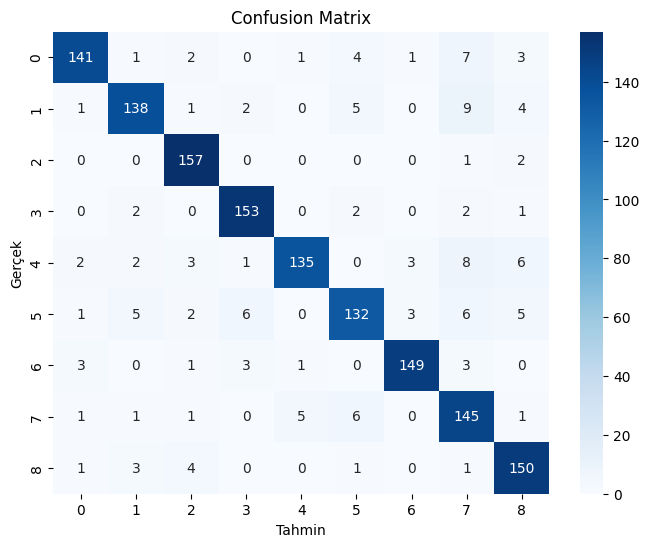

In [60]:
# Sınıflandırma raporu ve confusion matrix

# Tahmin yap
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_one_hot, axis=1)

# Sınıflandırma raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()